In [30]:
import numpy as np
import pandas as pd
import hdbscan

from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_pickle('../../data/processed/state0/left_ios_df.pkl')
print(df.shape)

(8529, 8)


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns)

In [ ]:
def calculate_gini_score(labels):
    counts = Counter(labels)
    if -1 in counts:
        del counts[-1]
    if len(counts) < 2:
        return 0.0 
    y = np.array(sorted(counts.values()))
    n = len(y)
    numerator = sum((2 * (i + 1) - n - 1) * y[i] for i in range(n))
    denominator = n * sum(y)

    gini = numerator / denominator
    
    return gini

In [5]:
results_list = []

In [6]:
# k means model

# possible k values
for k in [2, 3, 4, 5]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(scaled_df)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(scaled_df, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)

    results_list.append({
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k
    })    


In [7]:
N_total = X_scaled.shape[0]

In [8]:
# DBSCAN modeling
for eps in np.linspace(0.1, 2.0, 20):
    for min_pts in [2, 15]:
        db = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1).fit(X_scaled)
        labels = db.labels_
        
        non_noise_mask = labels != -1
        data_non_noise = X_scaled[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        n_clusters = len(np.unique(labels_non_noise))
        n_noise = np.sum(labels == -1)
    
        if n_clusters >= 2 and len(labels_non_noise) >= 2:
            sil_score = silhouette_score(data_non_noise, labels_non_noise)
        else:
            sil_score = np.nan 
            
        noise_percentage = (n_noise / N_total) * 100
        gini_score = calculate_gini_score(labels) 

        results_list.append({
            'model': 'dbscan',
            'HP (eps)': eps, 
            'HP (min_samp)': min_pts,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })

In [32]:
# HDBSCAN modeling
for min_samp in range(18, 60):
    for min_cluster_size in range(2, 40):
        if min_samp > min_cluster_size:
            continue  # optional: keep ms <= mcs

        clusterer = hdbscan.HDBSCAN(
            min_samples=min_samp,
            min_cluster_size=min_cluster_size,
            cluster_selection_method='eom',
            metric='euclidean',
            core_dist_n_jobs=-1
        )
        labels = clusterer.fit_predict(X_scaled)

        non_noise_mask = labels != -1
        data_non_noise = X_scaled[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]

        n_clusters = len(np.unique(labels_non_noise))
        n_noise = int((labels == -1).sum())
        noise_percentage = (n_noise / N_total) * 100.0

        # keep only target band; require enough points
        if not (2 <= n_clusters <= 5):
            continue
        if labels_non_noise.size < 2:
            continue
        if noise_percentage >= 15:
            continue

        sil_score = silhouette_score(data_non_noise, labels_non_noise)
        gini_score = calculate_gini_score(labels)  # noise-aware, normalized version

        results_list.append({
            'model': 'hdbscan',
            'HP (min_samp)': int(min_samp),
            'HP (min_clust)': int(min_cluster_size),
            'sil. #': float(sil_score),
            'Gini': float(gini_score),
            'noise %': float(noise_percentage),
            'clust. #': int(n_clusters),
        })

/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [35]:
results_df = pd.DataFrame(results_list)
results_df.head

<bound method NDFrame.head of       model    sil. #      Gini     noise %  clust. #  HP (eps)  HP (min_samp)
0    kmeans  0.242345  0.120237    0.000000         2       NaN            NaN
1    kmeans  0.308262  0.156564    0.000000         3       NaN            NaN
2    kmeans  0.319063  0.238686    0.000000         4       NaN            NaN
3    kmeans  0.249766  0.182577    0.000000         5       NaN            NaN
4    dbscan  0.602717  0.185437   95.579787       144       0.1            2.0
5    dbscan       NaN  0.000000  100.000000         0       0.1           15.0
6    dbscan  0.024193  0.568107   72.517294       465       0.2            2.0
7    dbscan  0.451576  0.368333   97.655059         6       0.2           15.0
8    dbscan -0.177511  0.728035   47.320905       534       0.3            2.0
9    dbscan  0.047904  0.585298   84.089577         4       0.3           15.0
10   dbscan -0.470700  0.864906   29.475906       366       0.4            2.0
11   dbscan  0.162828 

In [38]:
results_df = pd.DataFrame(results_list).sort_values(by=['Gini', 'noise %', 'clust. #'], ascending=[True,True, False])
#filtered_results = results_df[results_df['noise %'] <= 15.0]
filtered_results = results_df[results_df['clust. #'] >= 2]
filtered_results = filtered_results[filtered_results['sil. #'] > 0.25]
filtered_results

,model,sil. #,Gini,noise %,clust. #,HP (eps),HP (min_samp)
1,kmeans,0.308262,0.156564,0.000000,3,NaN,NaN
4,dbscan,0.602717,0.185437,95.579787,144,0.1,2.0
2,kmeans,0.319063,0.238686,0.000000,4,NaN,NaN
7,dbscan,0.451576,0.368333,97.655059,6,0.2,15.0
32,dbscan,0.429388,0.666196,0.386915,3,1.5,2.0
34,dbscan,0.428608,0.666196,0.304842,3,1.6,2.0
36,dbscan,0.425414,0.666197,0.234494,3,1.7,2.0
38,dbscan,0.425285,0.666197,0.211045,3,1.8,2.0
40,dbscan,0.425273,0.666197,0.199320,3,1.9,2.0
42,dbscan,0.424965,0.666197,0.175871,3,2.0,2.0


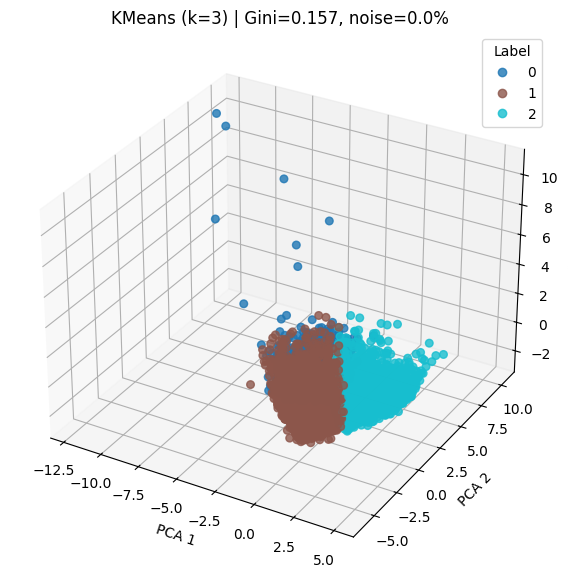

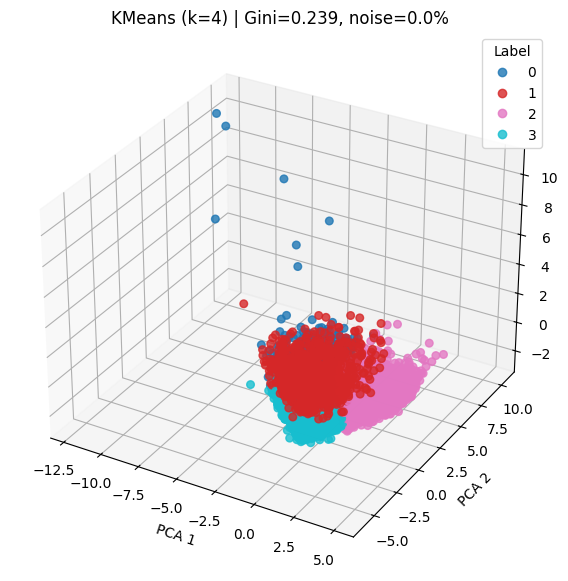

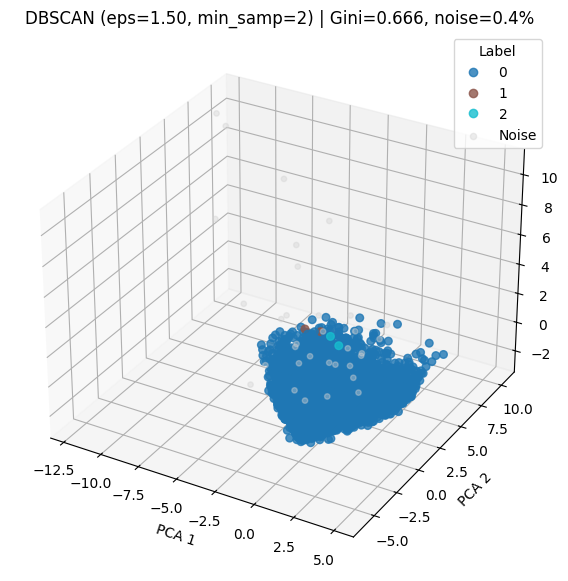

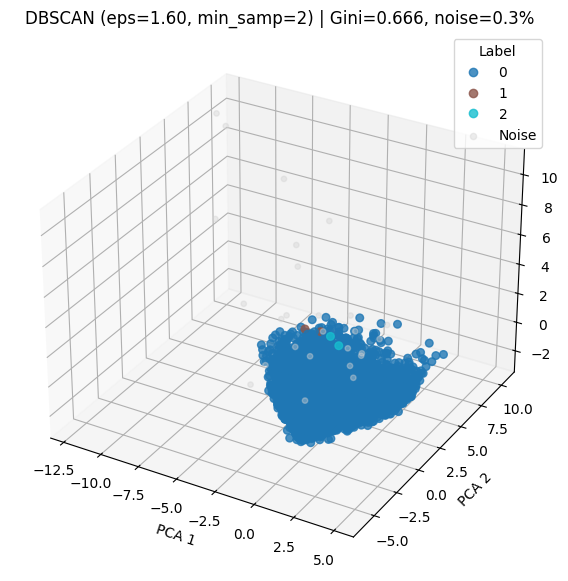

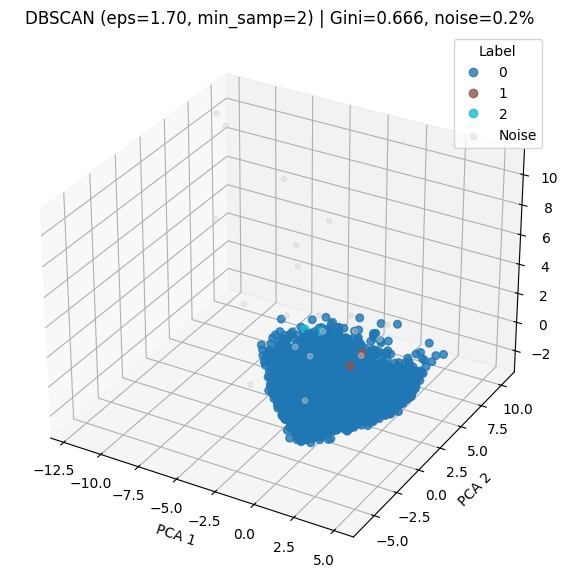

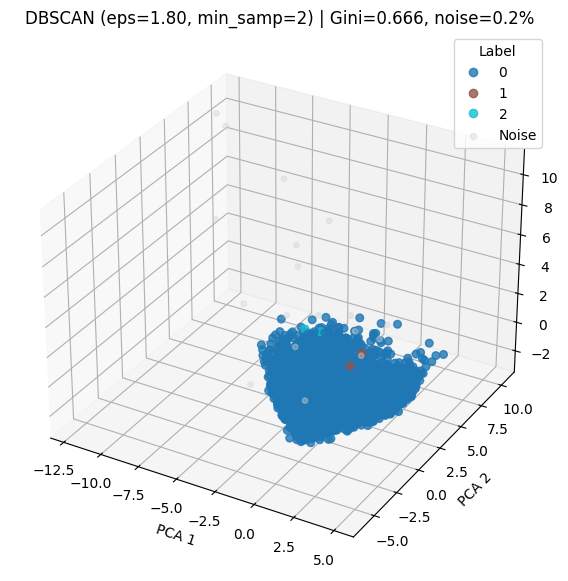

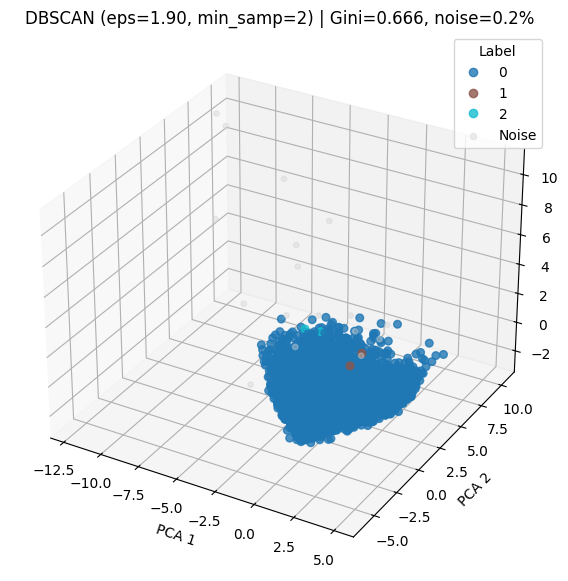

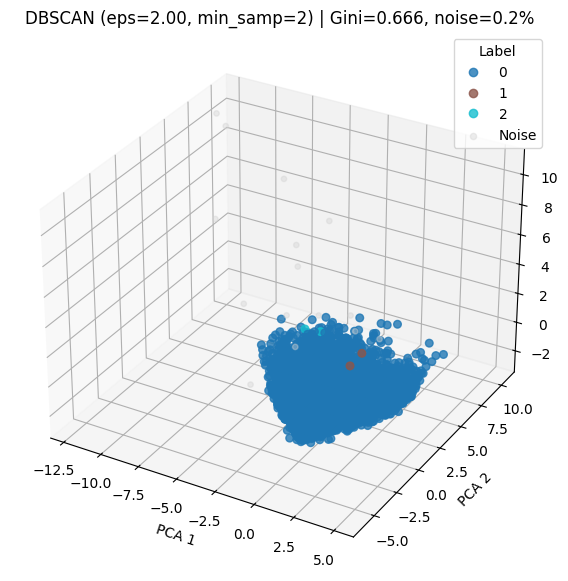

In [31]:
# Visualize every filtered clustering result in 3D PCA space
pca = PCA(n_components=3)
pca_coords = pca.fit_transform(X_scaled)

for idx, row in filtered_results.iterrows():
    model_name = row['model']
    if model_name == 'kmeans':
        clusterer = KMeans(n_clusters=int(row['clust. #']), random_state=42)
        title = f"KMeans (k={int(row['clust. #'])})"
    elif model_name == 'dbscan':
        eps = row.get('HP (eps)')
        min_samp = row.get('HP (min_samp)')
        if pd.isna(eps) or pd.isna(min_samp):
            continue
        clusterer = DBSCAN(eps=float(eps), min_samples=int(min_samp), n_jobs=-1)
        title = f"DBSCAN (eps={float(eps):.2f}, min_samp={int(min_samp)})"
    elif model_name == 'hdbscan':
        min_samp = row.get('HP (min_samp)')
        min_clust = row.get('HP (min_clust)')
        if pd.isna(min_samp):
            continue
        min_clust_int = int(min_clust) if pd.notna(min_clust) else None
        clusterer = hdbscan.HDBSCAN(min_samples=int(min_samp),
                                    min_cluster_size=min_clust_int)
        min_clust_desc = f", min_clust={int(min_clust)}" if pd.notna(min_clust) else ''
        title = f"HDBSCAN (min_samp={int(min_samp)}{min_clust_desc})"
    else:
        continue

    labels = clusterer.fit_predict(X_scaled)
    core_mask = labels != -1
    noise_mask = labels == -1

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = None
    if core_mask.any():
        scatter = ax.scatter(
            pca_coords[core_mask, 0],
            pca_coords[core_mask, 1],
            pca_coords[core_mask, 2],
            c=labels[core_mask],
            cmap='tab10',
            s=30,
            alpha=0.8
        )

    if noise_mask.any():
        ax.scatter(
            pca_coords[noise_mask, 0],
            pca_coords[noise_mask, 1],
            pca_coords[noise_mask, 2],
            c='lightgray',
            s=15,
            alpha=0.4
        )

    ax.set_title(f"{title} | Gini={row['Gini']:.3f}, noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')

    legend_handles = []
    legend_labels = []

    if scatter is not None:
        handles, labels_list = scatter.legend_elements()
        legend_handles.extend(handles)
        legend_labels.extend(labels_list)

    if noise_mask.any():
        noise_proxy = ax.scatter([], [], [], c='lightgray', s=20, alpha=0.4)
        legend_handles.append(noise_proxy)
        legend_labels.append('Noise')

    if legend_handles:
        ax.legend(legend_handles, legend_labels, title='Label')

    plt.show()
